In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
sample = pd.read_csv('sample_submission.csv')

In [4]:
sample

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
4995,4995,5
4996,4996,5
4997,4997,5
4998,4998,5


In [5]:
train.shape

(60000, 785)

In [6]:
train_label = train['label']
train_label = to_categorical(train_label,10)
train_image = train.iloc[:,1:].to_numpy()
test_image = test.iloc[:,1:].to_numpy()
train_image = train_image.reshape(-1,28,28,1)
test_image = test_image.reshape(-1,28,28,1)

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(train_image, train_label, test_size = 0.1, random_state=42)

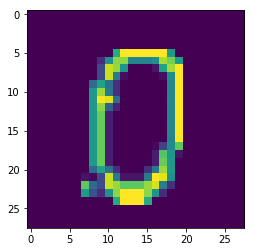

In [8]:
plt.imshow(X_train[1][:,:,0])

In [9]:
X_val.shape

(6000, 28, 28, 1)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.1,
                                   zoom_range = 0.25,
                                   horizontal_flip = False)

In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [12]:
keras.backend.clear_session()

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), padding = 'same', input_shape = (28,28,1)))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(64, (3,3), padding = 'same'))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3,3), padding = 'same'))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(128, (3,3), padding = 'same'))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3,3), padding = 'same'))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(256, (3,3), padding = 'same'))
model.add(layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation = 'softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)       

In [15]:
initial_learningrate=2e-3
batch_size = 1024
epochs = 50
input_shape = (28, 28, 1)

In [16]:
def lr_decay(epoch):#lrv
    return initial_learningrate * 0.99 ** epoch

In [17]:
import tensorflow as tf
config=tf.ConfigProto()
config.gpu_options.allow_growth = True
session=tf.Session(config=config)

model.compile(optimizer = RMSprop(lr=initial_learningrate) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
history = model.fit_generator(train_datagen.flow(train_image,train_label,batch_size=batch_size),
                              steps_per_epoch=100,
                              epochs=epochs,
                              callbacks=[LearningRateScheduler(lr_decay)],
                              validation_data=test_datagen.flow(X_val,Y_val),
                              validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[metrics/acc/Mean/_293]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [158]:
results=model.predict(test_image/255.)
results

array([[9.6058009e-15, 3.4381986e-14, 4.3032892e-14, ..., 1.8017253e-12,
        3.1306900e-17, 7.1660877e-16],
       [9.9999523e-01, 2.7423143e-06, 2.8258615e-08, ..., 8.1735568e-10,
        1.8645379e-06, 1.2458990e-07],
       [6.6916428e-08, 1.1835208e-10, 9.9999988e-01, ..., 4.2517895e-11,
        6.1429244e-09, 1.5720938e-10],
       ...,
       [3.0153946e-04, 9.9969840e-01, 1.7323911e-08, ..., 2.6570643e-08,
        1.2274781e-07, 5.1143401e-09],
       [1.6568856e-09, 1.4397329e-09, 8.7652698e-12, ..., 3.6325822e-08,
        1.4087655e-07, 3.9557017e-05],
       [8.7110908e-14, 2.6492854e-13, 1.1976689e-13, ..., 2.7153724e-13,
        1.7254408e-15, 5.4309385e-15]], dtype=float32)

In [159]:
results=np.argmax(results,axis=1)
results=pd.Series(results,name='label')
results

0       3
1       0
2       2
3       6
4       7
       ..
4995    1
4996    0
4997    1
4998    6
4999    3
Name: label, Length: 5000, dtype: int64

In [160]:
sample['label'] = results
sample.to_csv("submission.csv",index=False)

In [161]:
sample

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,0
4997,4997,1
4998,4998,6


In [162]:
results = model.evaluate(additional_image,additional_label)

10240/10240 [==============================] - 2s 159us/step


In [163]:
results

[0.5074403497721505, 0.90107421875]

In [103]:
sample

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6
